In [145]:
# Importing common libraries
import numpy as np 
import pandas as pd 

import seaborn as sns 
import matplotlib.pyplot as plt 

from scipy import stats
import statsmodels.formula.api as smf 
import statsmodels.api as sm 

from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.calibration import calibration_curve


import shap 

from sklearn.metrics import (confusion_matrix,ConfusionMatrixDisplay,precision_recall_curve,average_precision_score,roc_auc_score,roc_curve,classification_report)

In [5]:
# Loading the dataset 
df = pd.read_csv('synthetic_healthcare_1M.csv', parse_dates=['encounter_date'])

In [7]:
# Inspecting dataset 
df.dtypes

encounter_id                    int64
patient_id                      int64
hospital_id                     int64
encounter_date         datetime64[ns]
period                          int64
age                             int64
sex                            object
race                           object
insurance_type                 object
visit_type                     object
primary_diagnosis              object
comorbidity_score               int64
smoking_status                 object
systolic_bp                   float64
diastolic_bp                  float64
glucose                       float64
cholesterol                   float64
bmi                           float64
treatment_group                 int64
outcome_30d_readmit             int64
dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   encounter_id         1000000 non-null  int64         
 1   patient_id           1000000 non-null  int64         
 2   hospital_id          1000000 non-null  int64         
 3   encounter_date       1000000 non-null  datetime64[ns]
 4   period               1000000 non-null  int64         
 5   age                  1000000 non-null  int64         
 6   sex                  1000000 non-null  object        
 7   race                 1000000 non-null  object        
 8   insurance_type       1000000 non-null  object        
 9   visit_type           1000000 non-null  object        
 10  primary_diagnosis    1000000 non-null  object        
 11  comorbidity_score    1000000 non-null  int64         
 12  smoking_status       1000000 non-null  object        
 13

In [11]:
df.isnull().sum()

encounter_id           0
patient_id             0
hospital_id            0
encounter_date         0
period                 0
age                    0
sex                    0
race                   0
insurance_type         0
visit_type             0
primary_diagnosis      0
comorbidity_score      0
smoking_status         0
systolic_bp            0
diastolic_bp           0
glucose                0
cholesterol            0
bmi                    0
treatment_group        0
outcome_30d_readmit    0
dtype: int64

In [15]:
df.shape

(1000000, 20)

In [17]:
# Summary Statistics 
df.describe(include="all")

,encounter_id,patient_id,hospital_id,encounter_date,period,age,sex,race,insurance_type,visit_type,primary_diagnosis,comorbidity_score,smoking_status,systolic_bp,diastolic_bp,glucose,cholesterol,bmi,treatment_group,outcome_30d_readmit
count,1000000.000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,3,5,4,3,6,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,Female,White,Medicare,Outpatient,I10,NaN,Never,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,499438,500232,399317,500457,167243,NaN,600373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,500000.500000,99938.037106,10.499594,2020-12-31 17:27:19.929599744,0.500357,54.002258,NaN,NaN,NaN,NaN,NaN,4.993857,NaN,130.018416,79.991014,111.162852,190.174739,28.035771,0.249790,0.272613
min,1.000000,1.000000,1.000000,2018-01-01 00:00:00,0.000000,18.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,80.000000,40.000000,50.000000,100.000000,15.000000,0.000000,0.000000
25%,250000.750000,49940.000000,6.000000,2019-07-04 00:00:00,0.000000,36.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,116.465196,71.903311,83.065878,162.994508,23.950527,0.000000,0.000000
50%,500000.500000,99969.000000,10.000000,2021-01-01 00:00:00,1.000000,54.000000,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,129.985067,80.000534,109.974046,190.042245,27.993418,0.000000,0.000000
75%,750000.250000,149882.000000,15.000000,2022-07-02 00:00:00,1.000000,72.000000,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,143.455586,88.067994,136.974100,216.978034,32.056097,0.000000,1.000000
max,1000000.000000,200000.000000,20.000000,2023-12-31 00:00:00,1.000000,90.000000,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,219.863052,135.609933,312.279698,383.186218,56.755917,1.000000,1.000000


In [19]:
# Exploratory Data Analysis 
df.select_dtypes(include='object')

,sex,race,insurance_type,visit_type,primary_diagnosis,smoking_status
0,Male,Asian,Medicare,ED,J44,Former
1,Male,White,Commercial,ED,E11,Never
2,Male,White,Commercial,ED,J44,Never
3,Female,White,Commercial,Outpatient,J44,Former
4,Male,White,Medicare,Inpatient,N18,Never
...,...,...,...,...,...,...
999995,Male,Hispanic,Commercial,Outpatient,N18,Never
999996,Female,White,Self-pay,Inpatient,I50,Never
999997,Male,Hispanic,Commercial,Inpatient,J44,Never
999998,Male,Hispanic,Medicare,ED,J44,Former


In [21]:
# Value counts for the categorical columns 
cat_columns = ["sex","race","insurance_type","visit_type","primary_diagnosis","smoking_status","period","treatment_group","outcome_30d_readmit"]
for col in cat_columns:
    print(col)
    print(df[col].value_counts())
    print("-" * 30)

sex
sex
Female    499438
Male      480457
Other      20105
Name: count, dtype: int64
------------------------------
race
race
White       500232
Black       199914
Hispanic    150479
Asian        99239
Other        50136
Name: count, dtype: int64
------------------------------
insurance_type
insurance_type
Medicare      399317
Commercial    349975
Medicaid      200440
Self-pay       50268
Name: count, dtype: int64
------------------------------
visit_type
visit_type
Outpatient    500457
ED            299971
Inpatient     199572
Name: count, dtype: int64
------------------------------
primary_diagnosis
primary_diagnosis
I10    167243
I50    167080
E11    166781
N18    166712
Z00    166279
J44    165905
Name: count, dtype: int64
------------------------------
smoking_status
smoking_status
Never      600373
Former     249399
Current    150228
Name: count, dtype: int64
------------------------------
period
period
1    500357
0    499643
Name: count, dtype: int64
---------------------------

In [23]:
# Summmary statistics for numerical columns 
df.describe()

,encounter_id,patient_id,hospital_id,encounter_date,period,age,comorbidity_score,systolic_bp,diastolic_bp,glucose,cholesterol,bmi,treatment_group,outcome_30d_readmit
count,1000000.000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,99938.037106,10.499594,2020-12-31 17:27:19.929599744,0.500357,54.002258,4.993857,130.018416,79.991014,111.162852,190.174739,28.035771,0.249790,0.272613
min,1.000000,1.000000,1.000000,2018-01-01 00:00:00,0.000000,18.000000,0.000000,80.000000,40.000000,50.000000,100.000000,15.000000,0.000000,0.000000
25%,250000.750000,49940.000000,6.000000,2019-07-04 00:00:00,0.000000,36.000000,2.000000,116.465196,71.903311,83.065878,162.994508,23.950527,0.000000,0.000000
50%,500000.500000,99969.000000,10.000000,2021-01-01 00:00:00,1.000000,54.000000,5.000000,129.985067,80.000534,109.974046,190.042245,27.993418,0.000000,0.000000
75%,750000.250000,149882.000000,15.000000,2022-07-02 00:00:00,1.000000,72.000000,8.000000,143.455586,88.067994,136.974100,216.978034,32.056097,0.000000,1.000000
max,1000000.000000,200000.000000,20.000000,2023-12-31 00:00:00,1.000000,90.000000,10.000000,219.863052,135.609933,312.279698,383.186218,56.755917,1.000000,1.000000
std,288675.278933,57711.237986,5.764586,NaN,0.500000,21.086954,3.162838,19.887016,11.987459,37.684385,39.557133,5.921821,0.432892,0.445304


In [25]:
# Correlational analaysis against the target variable ~outcocome_30d_readmit
df.select_dtypes(include=['float','int']).corr()['outcome_30d_readmit'].sort_values(ascending=False).to_frame()

,outcome_30d_readmit
outcome_30d_readmit,1.000000
comorbidity_score,0.197882
age,0.173080
period,0.010798
hospital_id,0.005618
encounter_id,0.000584
patient_id,0.000354
cholesterol,-0.000004
systolic_bp,-0.000078
glucose,-0.000171


In [27]:
df.select_dtypes(include=['float','int'])

,encounter_id,patient_id,hospital_id,period,age,comorbidity_score,systolic_bp,diastolic_bp,glucose,cholesterol,bmi,treatment_group,outcome_30d_readmit
0,1,17851,10,0,78,8,153.901638,62.955217,173.863185,241.917563,36.987480,0,0
1,2,154792,3,1,65,10,153.500070,78.832247,109.673125,241.264842,30.962339,0,1
2,3,130915,19,0,59,4,117.332099,83.337680,78.392590,189.426129,45.568989,0,1
3,4,87776,8,0,50,7,89.918260,64.830774,111.133513,132.799341,15.000000,0,0
4,5,86604,8,1,41,6,124.390052,75.007090,97.376285,257.669613,20.935587,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999996,83899,12,0,31,0,152.234617,97.521717,120.492123,136.269745,19.607074,0,0
999996,999997,195412,9,1,48,6,131.682765,86.361396,74.513118,172.506543,31.129763,1,1
999997,999998,57001,2,0,35,8,117.993539,81.299525,113.524153,219.466140,19.490973,0,0
999998,999999,107527,7,0,63,10,117.580281,62.346435,118.541503,154.069105,27.547230,0,1


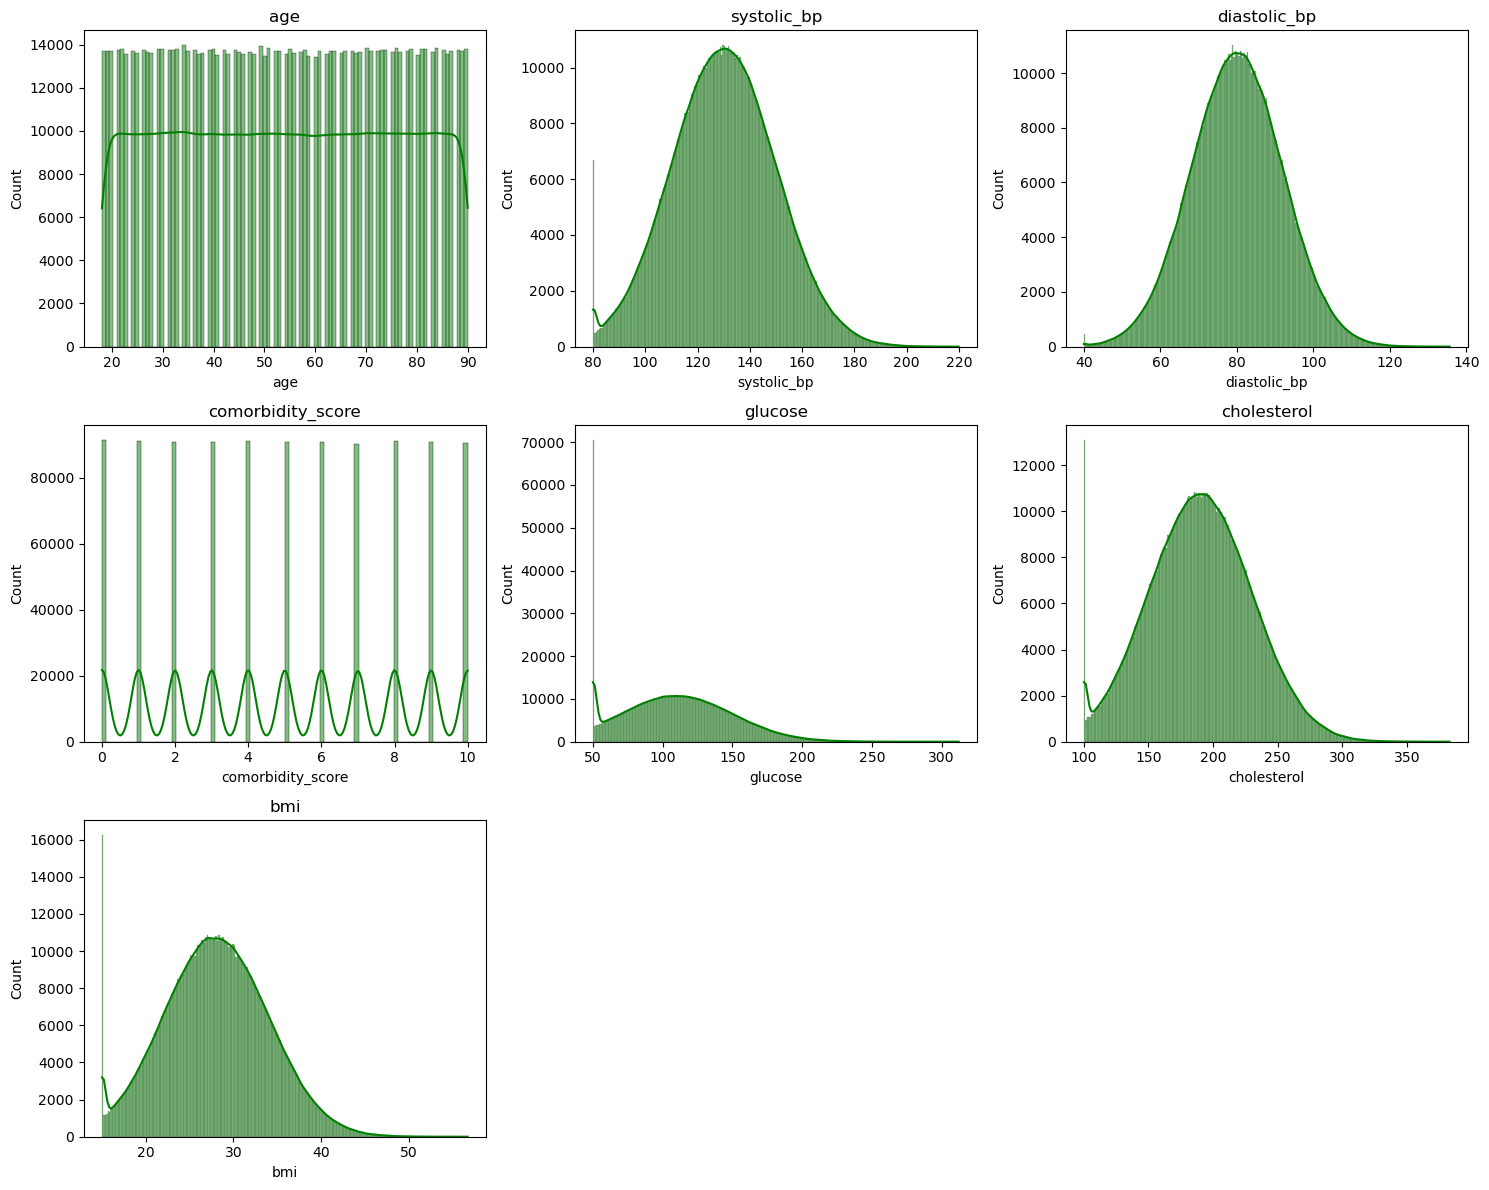

In [29]:
# Normality check (visual) [Histogram + Q-Q plots]
numeric_columns = ['age','systolic_bp','diastolic_bp','comorbidity_score','glucose','cholesterol','bmi']

# Histogram 
# Determine number of rows/cols
n = len(numeric_columns)
rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

axes = axes.flatten()  # flatten 2D array into 1D list

for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], kde=True, ax=axes[i], color='green')
    axes[i].set_title(col)

# Hide extra empty subplot(s) if any
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

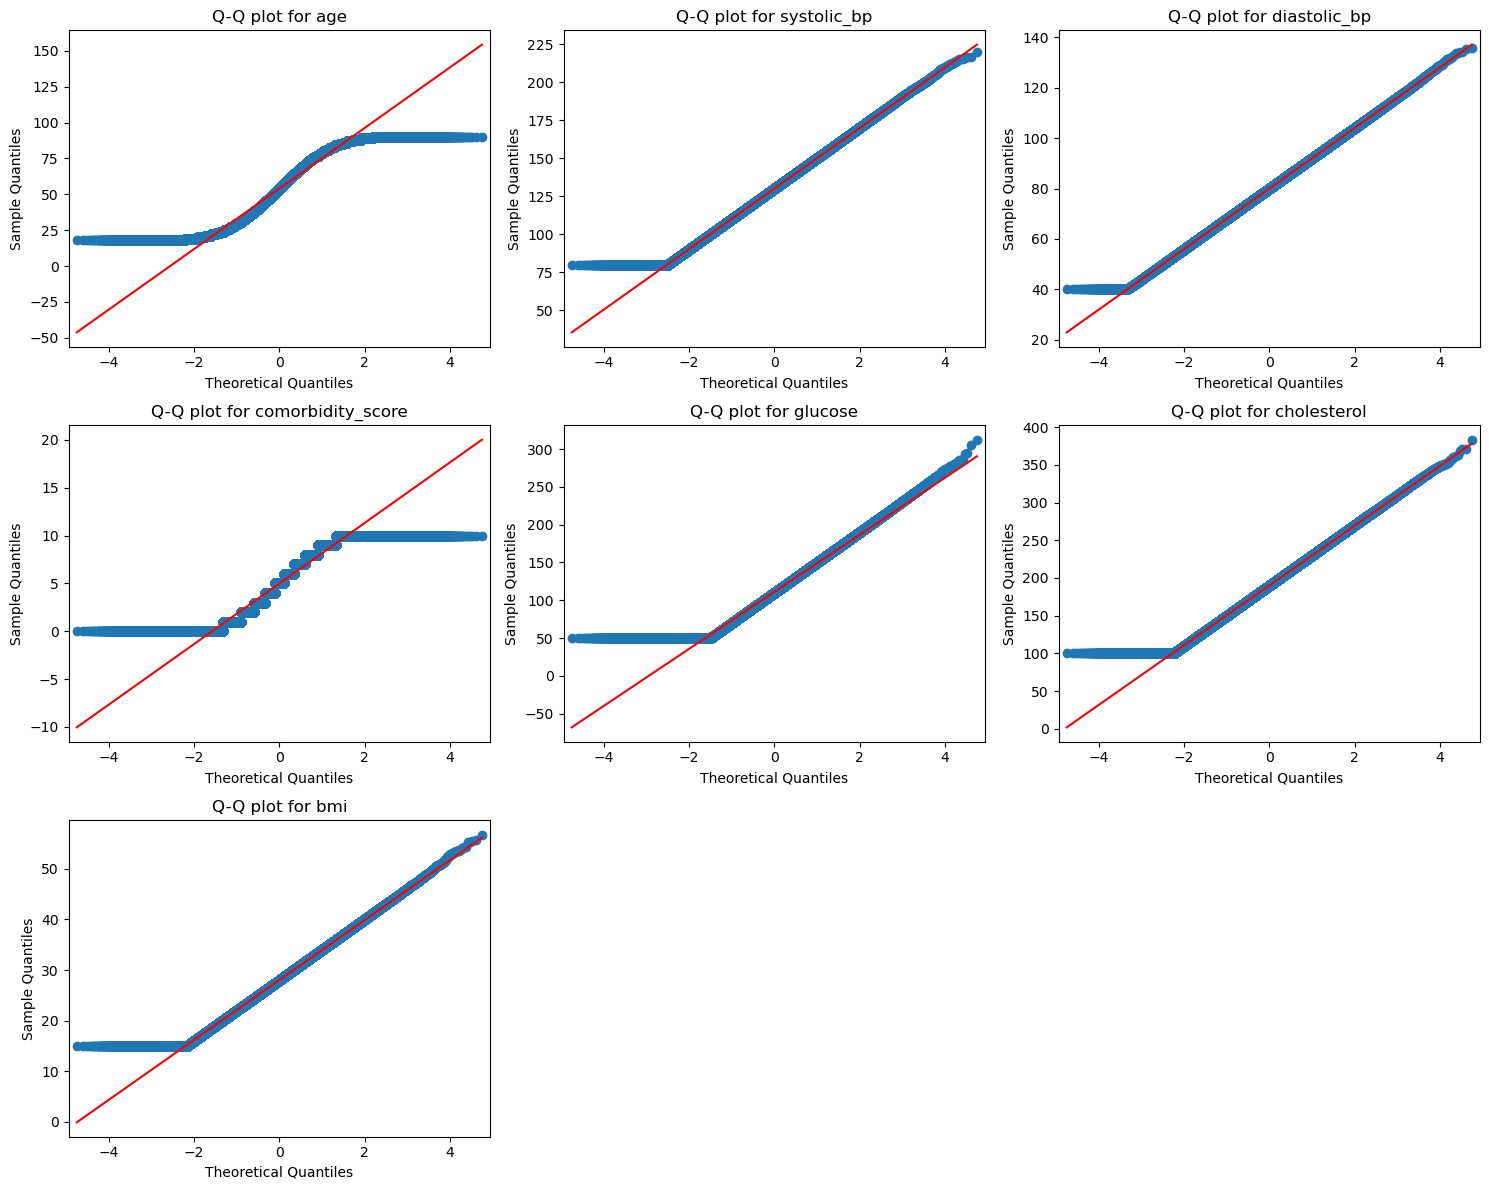

In [31]:
# Q-Q plots
numeric_columns = ['age','systolic_bp','diastolic_bp',
                   'comorbidity_score','glucose','cholesterol','bmi']

n = len(numeric_columns)
rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()  # make it 1-D so we can index

for i, col in enumerate(numeric_columns):
    sm.qqplot(df[col].dropna(), line='s', ax=axes[i])
    axes[i].set_title(f"Q-Q plot for {col}")

# Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [33]:
# Normality check (analytical) [Shapiro Wilk Test + Kolmogorov Smirnov Test]

# Shapiro Wilk Test (Since the Shapiro Wilk Test does not scale ~1 million rows ; 5000 rows are sampled ) 
sample = df[numeric_columns].sample(5000, random_state=42)
for col in numeric_columns:
    stat,p = stats.shapiro(sample[col])
    print(col,"has a shapiro wilk p value of",p)
    print("-" * 60)

age has a shapiro wilk p value of 7.990989351784241e-37
------------------------------------------------------------
systolic_bp has a shapiro wilk p value of 0.0008320197114554462
------------------------------------------------------------
diastolic_bp has a shapiro wilk p value of 0.725439421948876
------------------------------------------------------------
comorbidity_score has a shapiro wilk p value of 5.702130878712703e-41
------------------------------------------------------------
glucose has a shapiro wilk p value of 6.228669354987503e-27
------------------------------------------------------------
cholesterol has a shapiro wilk p value of 2.1155799358001238e-08
------------------------------------------------------------
bmi has a shapiro wilk p value of 4.137855856866531e-10
------------------------------------------------------------


In [35]:
# Kolmogorov Smirnov Test 
for col in numeric_columns:
    series = df[col]
    mu, sigma = series.mean(), series.std()
    stat,p = stats.kstest(series,"norm",args=(mu,sigma))
    print(col,"has p value of",p)

age has p value of 0.0
systolic_bp has p value of 3.5865613381471733e-31
diastolic_bp has p value of 0.8509045256001425
comorbidity_score has p value of 0.0
glucose has p value of 0.0
cholesterol has p value of 1.2030096092238434e-111
bmi has p value of 3.210530239033092e-167


In [37]:
# Mean scores for the treatment groups
cols = ['glucose','systolic_bp','diastolic_bp','cholesterol','bmi']
mean_table = df.groupby('treatment_group')[cols].mean().T
mean_table

treatment_group,0,1
glucose,111.196676,111.061264
systolic_bp,130.003755,130.062448
diastolic_bp,79.999591,79.965252
cholesterol,190.176989,190.167982
bmi,28.034237,28.040380


In [20]:
# Hypothesis testing 
# Two Sample Ttest on the treatment group ~ [glucose, systolic bp, diastolic bp, cholesterol, bmi]

In [39]:
# Glucose 
treated = df[df["treatment_group"] == 1]["glucose"]
control = df[df["treatment_group"] == 0]["glucose"]
tstat, pval = stats.ttest_ind(treated,control)
print("p_value :",pval)

p_value : 0.11982180273552376


In [41]:
# systolic_bp 
treated = df[df["treatment_group"] == 1]["systolic_bp"]
control = df[df["treatment_group"] == 0]["systolic_bp"]
tstat,pval = stats.ttest_ind(treated,control)
print("p_value :",pval)

p_value : 0.2013948318540071


In [43]:
# diastolic_bp 
treated = df[df["treatment_group"] == 1]["diastolic_bp"]
control = df[df["treatment_group"] == 0]["diastolic_bp"]
tstat,pval = stats.ttest_ind(treated,control)
print("p_value :",pval)

p_value : 0.2149622486494586


In [45]:
# cholesterol 
treated = df[df["treatment_group"] == 1]["cholesterol"]
control = df[df["treatment_group"] == 0]["cholesterol"]
tstat,pval = stats.ttest_ind(treated,control)
print("p_value :",pval)

p_value : 0.9214806581886217


In [47]:
# bmi 
treated = df[df["treatment_group"] == 1]["bmi"]
control = df[df["treatment_group"] == 0]["bmi"]
tstat,pval = stats.ttest_ind(treated,control)
print("p_value :",pval)

p_value : 0.6533989905185635


In [49]:
# Chi-squared Test 
# Treatment group + outcome group 
contigency = pd.crosstab(df["treatment_group"],df["outcome_30d_readmit"])
chi2,p,dof,expected = stats.chi2_contingency(contigency)
print("Chi2:",chi2,"p-val:",p)

Chi2: 865.0071951843363 p-val: 3.9719496667217964e-190


In [51]:
# Causal Inference - Difference in Differences
did_df = df.copy()
formular = "outcome_30d_readmit ~ treatment_group * period + age + comorbidity_score"
did_model = smf.logit(formula=formular,data=did_df)
did_result = did_model.fit()
did_result.summary()


Optimization terminated successfully.
         Current function value: 0.549129
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     outcome_30d_readmit   No. Observations:              1000000
Model:                           Logit   Df Residuals:                   999994
Method:                            MLE   Df Model:                            5
Date:                 Mon, 15 Dec 2025   Pseudo R-squ.:                 0.06266
Time:                         18:37:46   Log-Likelihood:            -5.4913e+05
converged:                        True   LL-Null:                   -5.8584e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.9080          0       -inf      0.000      -2.908      -2.908
treatment_group           -0.1467        nan        nan        nan         nan         nan
period                     0.1930      0.005     36.308      0.000       0.183       0.203
treatment_group:period    -0.1467        nan        nan        nan         nan         nan
age                        0.0197        nan        nan        nan         nan         nan
comorbidity_score          0.1501      0.004     38.964      0.000       0.143       0.158
==========================================================================================
"""

In [53]:
# Data Preprocessing for ML 
df.dtypes

encounter_id                    int64
patient_id                      int64
hospital_id                     int64
encounter_date         datetime64[ns]
period                          int64
age                             int64
sex                            object
race                           object
insurance_type                 object
visit_type                     object
primary_diagnosis              object
comorbidity_score               int64
smoking_status                 object
systolic_bp                   float64
diastolic_bp                  float64
glucose                       float64
cholesterol                   float64
bmi                           float64
treatment_group                 int64
outcome_30d_readmit             int64
dtype: object

In [55]:
# Define the target col and the feature cols 
target_col = "outcome_30d_readmit"
feature_cols = ["hospital_id","period","age","sex","race","insurance_type","visit_type",
                "primary_diagnosis","comorbidity_score","smoking_status","systolic_bp","diastolic_bp","glucose",
                "cholesterol","bmi","treatment_group"]
X = df[feature_cols]
y = df[target_col]

In [57]:
# Split the feature columns into catgeorical and numerical 
numerical_features = ["age","systolic_bp","diastolic_bp","glucose",
                "cholesterol","bmi","comorbidity_score"]
categorical_features = ["hospital_id","period","sex","race","insurance_type","visit_type",
                        "primary_diagnosis","smoking_status"]

In [59]:
# Numeric transformer and categorical transformer 
numerical_transformer = Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),
                                         ("scaler",StandardScaler())])
categorical_transformer = Pipeline(steps=[("imputer",SimpleImputer(strategy="most_frequent")),
                                          ("onehot",OneHotEncoder(handle_unknown="ignore", min_frequency=50, sparse_output=True))])

In [61]:
# Numeric preprocessing and catgeorical preprocessing 
preprocessor = ColumnTransformer(transformers=[("num",numerical_transformer,numerical_features),
                                              ("cat",categorical_transformer,categorical_features)])


In [63]:
# train-val-test split 
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)
X_valid,X_test,y_valid,y_test = train_test_split(X_temp,y_temp,test_size=0.5,random_state=42,stratify=y_temp)

In [ ]:
# Model Building 

In [65]:
# Logistic Regression 
log_reg_clf = Pipeline(steps=[("preprocess",preprocessor),
                             ("clf",LogisticRegression(max_iter=1000))])
log_reg_clf.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'systolic_bp',
                                                   'diastolic_bp', 'glucose',
                                                   'cholesterol', 'bmi',
                                                   'comorbidity_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=50))]),
                                                  ['hospital_id', 'period',
                                                   'sex', 'race',
                                                   'insurance_type',
                                                   'visit_type',
                                                   'primary_diagnosis',
                                                   'smoking_status'])])),
                ('clf', LogisticRegression(max_iter=1000))])

In [67]:
# Random Forest
rf_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=50,
        max_depth=12,
        min_samples_leaf=10,
        n_jobs=-1,
        random_state=42
    ))
])
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'systolic_bp',
                                                   'diastolic_bp', 'glucose',
                                                   'cholesterol', 'bmi',
                                                   'comorbidity_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=50))]),
                                                  ['hospital_id', 'period',
                                                   'sex', 'race',
                                                   'insurance_type',
                                                   'visit_type',
                                                   'primary_diagnosis',
                                                   'smoking_status'])])),
                ('clf',
                 RandomForestClassifier(max_depth=12, min_samples_leaf=10,
                                        n_estimators=50, n_jobs=-1,
                                        random_state=42))])

In [83]:
# XgBoost 
xg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",        
        n_estimators=400,         
        learning_rate=0.05,       
        max_depth=6,              
        min_child_weight=10,      
        subsample=0.8,            
        colsample_bytree=0.8,     
        reg_lambda=1.0,           
        reg_alpha=0.0,            
        random_state=42
        n_jobs=-1
    ))
])
xg_clf.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'systolic_bp',
                                                   'diastolic_bp', 'glucose',
                                                   'cholesterol', 'bmi',
                                                   'comorbidity_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(han...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [ ]:
# Baseline model evaluation on validation set

In [85]:
models = {"log_reg" : log_reg_clf,"rf" : rf_clf,"xg" : xg_clf}
for name,model in models.items():
    y_proba = model.predict_proba(X_valid)[:,1]
    auc = roc_auc_score(y_valid,y_proba)
    print(name,auc)

log_reg 0.6718459059619672
rf 0.6666797512297269
xg 0.6712940976342314


In [ ]:
# based on auc scores random forest is dropped 

In [ ]:
# The best candidate models logistic regression and xgboost 

In [ ]:
# Primary metric to optimize - Recall

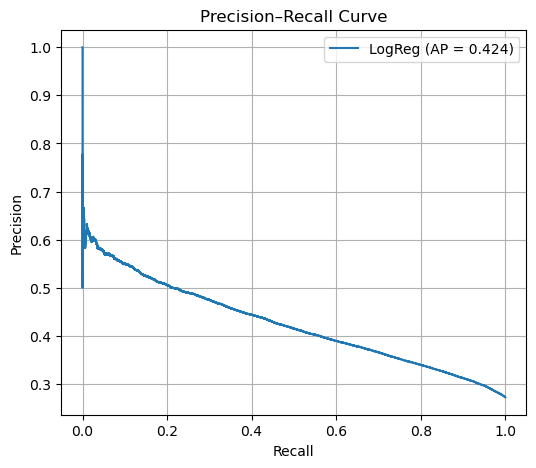

In [101]:
# Vizualizing a PR curve (log_reg )
y_val_proba = log_reg_clf.predict_proba(X_valid)[:,1]
precision, recall, thresholds = precision_recall_curve(y_valid, y_val_proba)
ap = average_precision_score(y_valid, y_val_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"LogReg (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

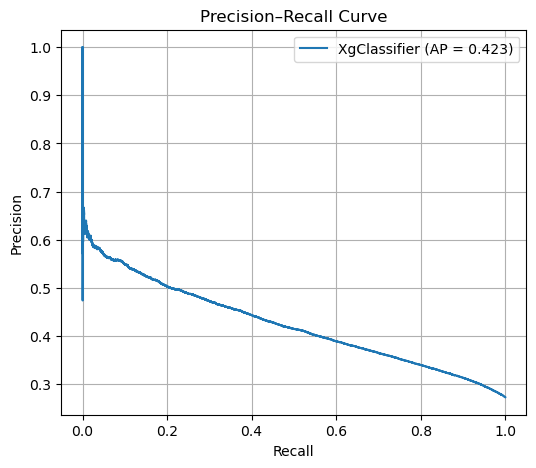

In [103]:
# Vizualizing a PR curve (xg_clf )
y_val_proba = xg_clf.predict_proba(X_valid)[:,1]
precision, recall, thresholds = precision_recall_curve(y_valid, y_val_proba)
ap = average_precision_score(y_valid, y_val_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"XgClassifier (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [121]:
# Business constraints
target_recall = 0.70
target_precision = 0.30

# Find indices satisfying BOTH constraints
valid_idxs = np.where(
    (recall[:-1] >= target_recall) & 
    (precision[:-1] >= target_precision)
)[0]

if len(valid_idxs) == 0:
    print("No threshold satisfies both constraints.")
else:
    # Among valid thresholds, choose the one with MAX recall
    best_idx = valid_idxs[np.argmax(recall[valid_idxs])]
    
    chosen_threshold = thresholds[best_idx]
    
    print("Chosen threshold:", chosen_threshold)
    print("Recall at threshold:", recall[best_idx])
    print("Precision at threshold:", precision[best_idx])

Chosen threshold: 0.14277425
Recall at threshold: 0.9403061723564511
Precision at threshold: 0.3


In [123]:
# Freezing threshold 
final_threshold = chosen_threshold

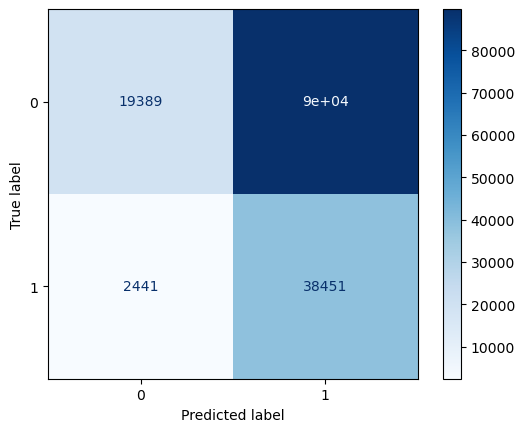

In [131]:
# Confusion Matrix
y_valid_pred = (y_val_proba >= final_threshold).astype(int)

ConfusionMatrixDisplay.from_predictions(
    y_valid,
    y_valid_pred,
    cmap="Blues"
)

In [135]:
# Classification Report 
print(classification_report(y_valid,y_valid_pred))

              precision    recall  f1-score   support

           0       0.89      0.18      0.30    109108
           1       0.30      0.94      0.45     40892

    accuracy                           0.39    150000
   macro avg       0.59      0.56      0.38    150000
weighted avg       0.73      0.39      0.34    150000



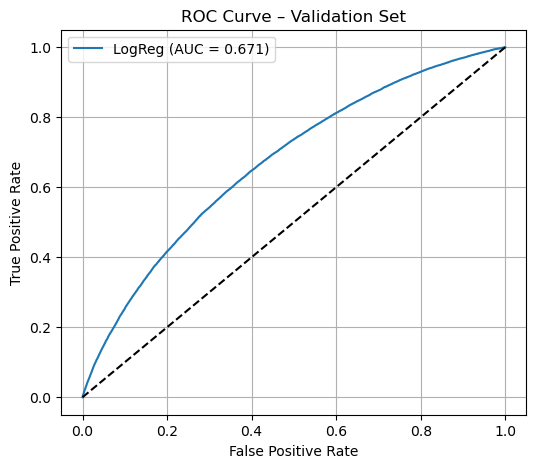

In [139]:
# ROC Curve for Documentation 
fpr, tpr, _ = roc_curve(y_valid, y_val_proba)
auc_score = roc_auc_score(y_valid, y_val_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {auc_score:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Validation Set")
plt.legend()
plt.grid(True)
plt.show()

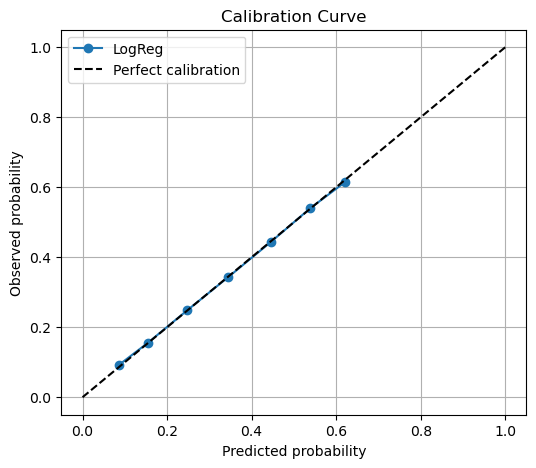

In [147]:
# Calibration Check 
prob_true, prob_pred = calibration_curve(
    y_valid, y_val_proba, n_bins=10
)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label="LogReg")
plt.plot([0,1], [0,1], "k--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed probability")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()

In [149]:
# Brier Score 
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_valid, y_val_proba)
print("Brier score:", brier)

Brier score: 0.1837969832045164


In [ ]:
# Final evaluation on Test set 

In [151]:
# Predicted probabilites on the test set 
y_test_proba = log_reg_clf.predict_proba(X_test)[:, 1]

In [153]:
# Predictions on test set
y_test_pred = (y_test_proba >= chosen_threshold).astype(int)

In [155]:
# Confusion matrix 
cm_test = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(cm_test)

Test Confusion Matrix:
[[19555 89553]
 [ 2456 38436]]


In [157]:
# Classification Report 
print("Final Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Final Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.18      0.30    109108
           1       0.30      0.94      0.46     40892

    accuracy                           0.39    150000
   macro avg       0.59      0.56      0.38    150000
weighted avg       0.73      0.39      0.34    150000



In [161]:
# ROC-AUC on test set 
test_auc = roc_auc_score(y_test, y_test_proba)
print("Final Test ROC-AUC:", test_auc)

Final Test ROC-AUC: 0.6728734798012819


In [163]:
test_ap = average_precision_score(y_test, y_test_proba)
print("Final Test Average Precision (PR-AUC):", test_ap)

Final Test Average Precision (PR-AUC): 0.424069354079082


In [165]:
test_brier = brier_score_loss(y_test, y_test_proba)
print("Final Test Brier Score:", test_brier)

Final Test Brier Score: 0.18362296782372775


In [167]:
# Saving the trained pipeline 
import joblib

joblib.dump({
    "model": log_reg_clf,
    "threshold": chosen_threshold
}, "model.pkl")

['model.pkl']

In [171]:
!pip install fastapi uvicorn

In [173]:
from fastapi import FastAPI
import fastapi
import uvicorn
import joblib
import pandas as pd

app = FastAPI(title="Readmission Risk API")

# Load model
bundle = joblib.load("model.pkl")
model = bundle["model"]
THRESHOLD = bundle["threshold"]

@app.post("/predict")
def predict(patient: dict):
    df = pd.DataFrame([patient])

    # Predict probability
    proba = model.predict_proba(df)[0, 1]

    # Apply frozen threshold
    prediction = int(proba >= THRESHOLD)

    return {
        "readmission_probability": round(float(proba), 4),
        "predicted_readmission": prediction
    }